# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Cam/gia_cam_thoi_tiet.csv"

In [3]:
var_file_name = 'var_gia_cam_thoi_tiet.joblib'
varma_file_name = 'varma_cam_lua_thoi_tiet.joblib'


## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

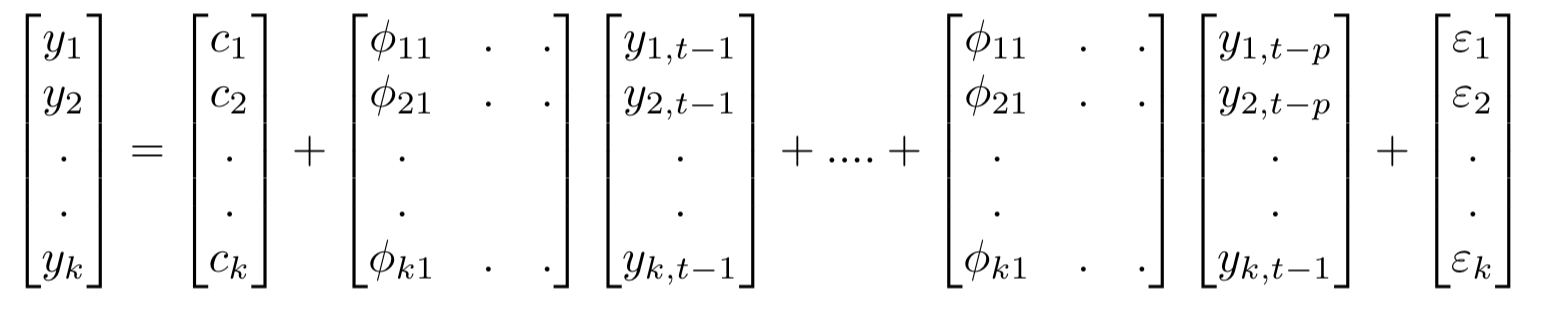

In [4]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [5]:
df.set_index('date', inplace=True)

In [6]:
df.head()

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
date,,,,,,,,
2007-07-17,16000.0,82.8,75.6,92.5,1.650,247.0,5.2,1011.0
2007-07-19,16000.0,80.6,77.4,92.8,1.650,247.0,5.4,1011.0
2007-07-20,16000.0,83.5,77.4,92.8,4.291,247.0,5.4,1011.0
2007-07-23,16000.0,82.9,77.0,91.4,4.291,247.0,5.2,1011.0
2007-07-24,16000.0,81.0,75.2,93.6,4.291,247.0,5.2,1011.0


<Axes: >

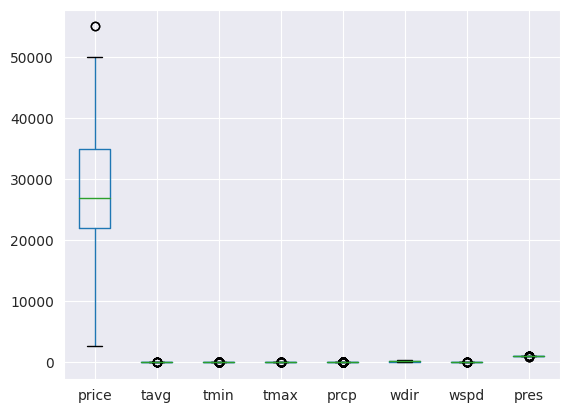

In [7]:
df.boxplot()

In [8]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 2


<Axes: >

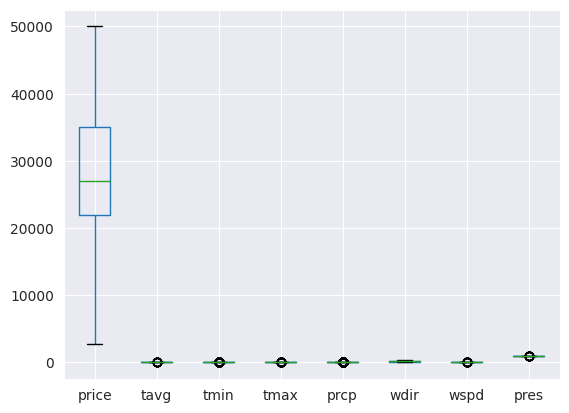

In [9]:
df.boxplot()

In [10]:
df = df.dropna()

In [11]:
fillter_feature = ['price', 'tavg', 'tmax', 'pres']
df = df[fillter_feature]

In [12]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,tavg,tmax,pres
price,1.000000,0.151000,0.048452,-0.070885
tavg,0.151000,1.000000,0.771060,-0.163334
tmax,0.048452,0.771060,1.000000,0.059239
pres,-0.070885,-0.163334,0.059239,1.000000


In [13]:
from google.colab import files
df.to_csv('./gia_cam_thoi_tiet.csv')
files.download('./gia_cam_thoi_tiet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: xlabel='date'>

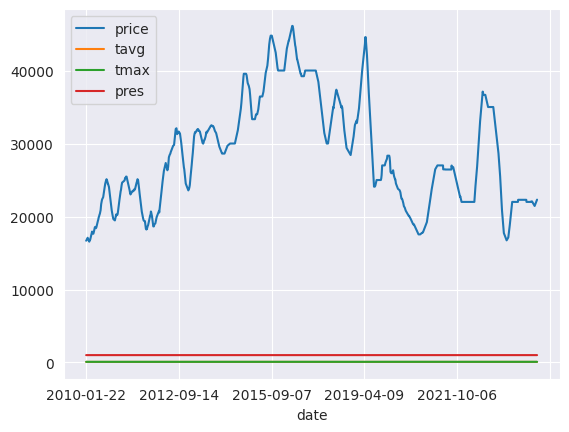

In [ ]:
df = df.rolling(45).mean()
df = df.dropna()
df.plot()

In [ ]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,tavg,tmax,pres
price,1.000000,0.226243,0.085193,-0.106794
tavg,0.226243,1.000000,0.823184,-0.375457
tmax,0.085193,0.823184,1.000000,0.060283
pres,-0.106794,-0.375457,0.060283,1.000000


In [ ]:
nobs = int(len(df)*0.7)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1702, 4)
(730, 4)


In [ ]:
from google.colab import files


## Kiểm tra stationary

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8935
 No. Lags Chosen       = 2
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0461. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6188
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tmax" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [ ]:
df_differenced = df_train.diff().dropna()

In [ ]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6469
 No. Lags Chosen       = 1
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9723
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tmax" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

## Train model VAR

In [ ]:
model = VAR(df_differenced)
for i in range(1, 50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -8.877062671105282
BIC :  -8.813081688398878
FPE :  0.00013955348805735646
HQIC:  -8.853376705040063 

Lag Order = 2
AIC :  -8.968668897145037
BIC :  -8.853447811576943
FPE :  0.00012733762928503152
HQIC:  -8.926012416613977 

Lag Order = 3
AIC :  -8.998771117352039
BIC :  -8.83226067502147
FPE :  0.00012356170134705826
HQIC:  -8.937124762722583 

Lag Order = 4
AIC :  -9.01430659617221
BIC :  -8.796457465921222
FPE :  0.0001216571256820474
HQIC:  -8.93365097658183 

Lag Order = 5
AIC :  -9.016279673724535
BIC :  -8.747042446971259
FPE :  0.00012141761258051403
HQIC:  -8.916595367012143 

Lag Order = 6
AIC :  -9.035059402260607
BIC :  -8.71438459283202
FPE :  0.00011915911644979623
HQIC:  -8.916326954897775 

Lag Order = 7
AIC :  -9.02693232275853
BIC :  -8.654770366722762
FPE :  0.00012013205745892901
HQIC:  -8.88913224978051 

Lag Order = 8
AIC :  -9.025463517126717
BIC :  -8.601764772624902
FPE :  0.00012030940435247754
HQIC:  -8.868576302063286 

Lag Order = 9
A

In [ ]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,-5.927,-5.914,0.002665,-5.923
1,-8.839,-8.773,0.0001450,-8.815
2,-8.929,-8.811*,0.0001325,-8.885
3,-8.960,-8.790,0.0001284,-8.897
4,-8.976,-8.753,0.0001264,-8.893
5,-8.979,-8.704,0.0001261,-8.877
6,-8.999,-8.671,0.0001235,-8.878
7,-8.992,-8.612,0.0001244,-8.851
8,-8.992,-8.559,0.0001244,-8.831
9,-8.985,-8.500,0.0001253,-8.805


In [ ]:
model_var = model.fit(49)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Jun, 2024
Time:                     04:12:20
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -7.37792
Nobs:                     1652.00    HQIC:                  -9.00169
Log likelihood:          -362.746    FPE:                4.75470e-05
AIC:                     -9.95835    Det(Omega_mle):     3.02981e-05
--------------------------------------------------------------------
Results for equation price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.280452         1.190435            0.236           0.814
L1.price          0.799443         0.026214           30.496           0.000
L1.tavg         -25.417753        35.485274           -0.716           0.474

In [ ]:
def adjust(val, length= 6): return str(val).ljust(length)

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.0
tavg   : 2.0
tmax   : 2.0
pres   : 2.0


In [ ]:
# Get the lag order
lag_order = model_var.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

49


array([[ 6.66666667e+01,  1.24444444e-01,  2.40000000e-01,
         7.55555556e-02],
       [ 6.66666667e+01,  5.33333333e-02,  8.00000000e-02,
         5.55555556e-02],
       [ 6.66666667e+01,  1.00000000e-01,  1.60000000e-01,
         1.55555556e-02],
       [-1.77777778e+02,  8.00000000e-02,  1.20000000e-01,
         3.55555556e-02],
       [-1.77777778e+02,  8.00000000e-02,  1.20000000e-01,
        -4.44444444e-03],
       [-1.77777778e+02,  5.33333333e-02,  8.00000000e-02,
        -2.27373675e-13],
       [-1.33333333e+02,  9.55555556e-02,  4.00000000e-02,
        -1.77777778e-02],
       [-1.33333333e+02,  1.77777778e-02,  4.00000000e-02,
         0.00000000e+00],
       [-8.88888889e+01,  3.11111111e-02,  4.00000000e-02,
        -2.44444444e-02],
       [-8.88888889e+01,  4.88888889e-02,  4.00000000e-02,
        -6.00000000e-02],
       [-8.88888889e+01,  7.33333333e-02,  8.00000000e-02,
        -3.33333333e-02],
       [-8.88888889e+01,  9.11111111e-02,  1.20000000e-01,
      

In [ ]:
import joblib
joblib.dump(model_var, 'var_gia_lua.joblib')

['var_gia_lua.joblib']

In [ ]:
from google.colab import files
files.download('var_gia_lua.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Forecast
nobs = len(df_test)
fc = model_var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,price_2d,tavg_2d,tmax_2d,pres_2d
date,,,,
2020-05-22,-4.076551,0.040265,-0.025168,-0.066157
2020-05-25,1.444120,0.023602,-0.038190,-0.080335
2020-05-26,-4.863691,-0.023038,-0.034125,-0.082098
2020-05-27,-2.194563,0.001414,-0.022731,-0.070580
2020-05-28,-23.916698,0.009536,-0.049474,-0.048098
...,...,...,...,...
2024-02-28,2.710078,0.001199,0.000104,-0.000862
2024-02-29,2.746512,0.001162,0.000178,-0.000961
2024-03-04,2.784526,0.001218,0.000235,-0.001000


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+ '_2d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['price_forecast']]

,price_forecast
date,
2020-05-22,22440.367893
2020-05-25,22441.812013
2020-05-26,22436.948322
2020-05-27,22434.753759
2020-05-28,22410.837061
...,...
2024-02-28,23293.178364
2024-02-29,23295.924877
2024-03-04,23298.709403


### Đánh giá mô hình VAR

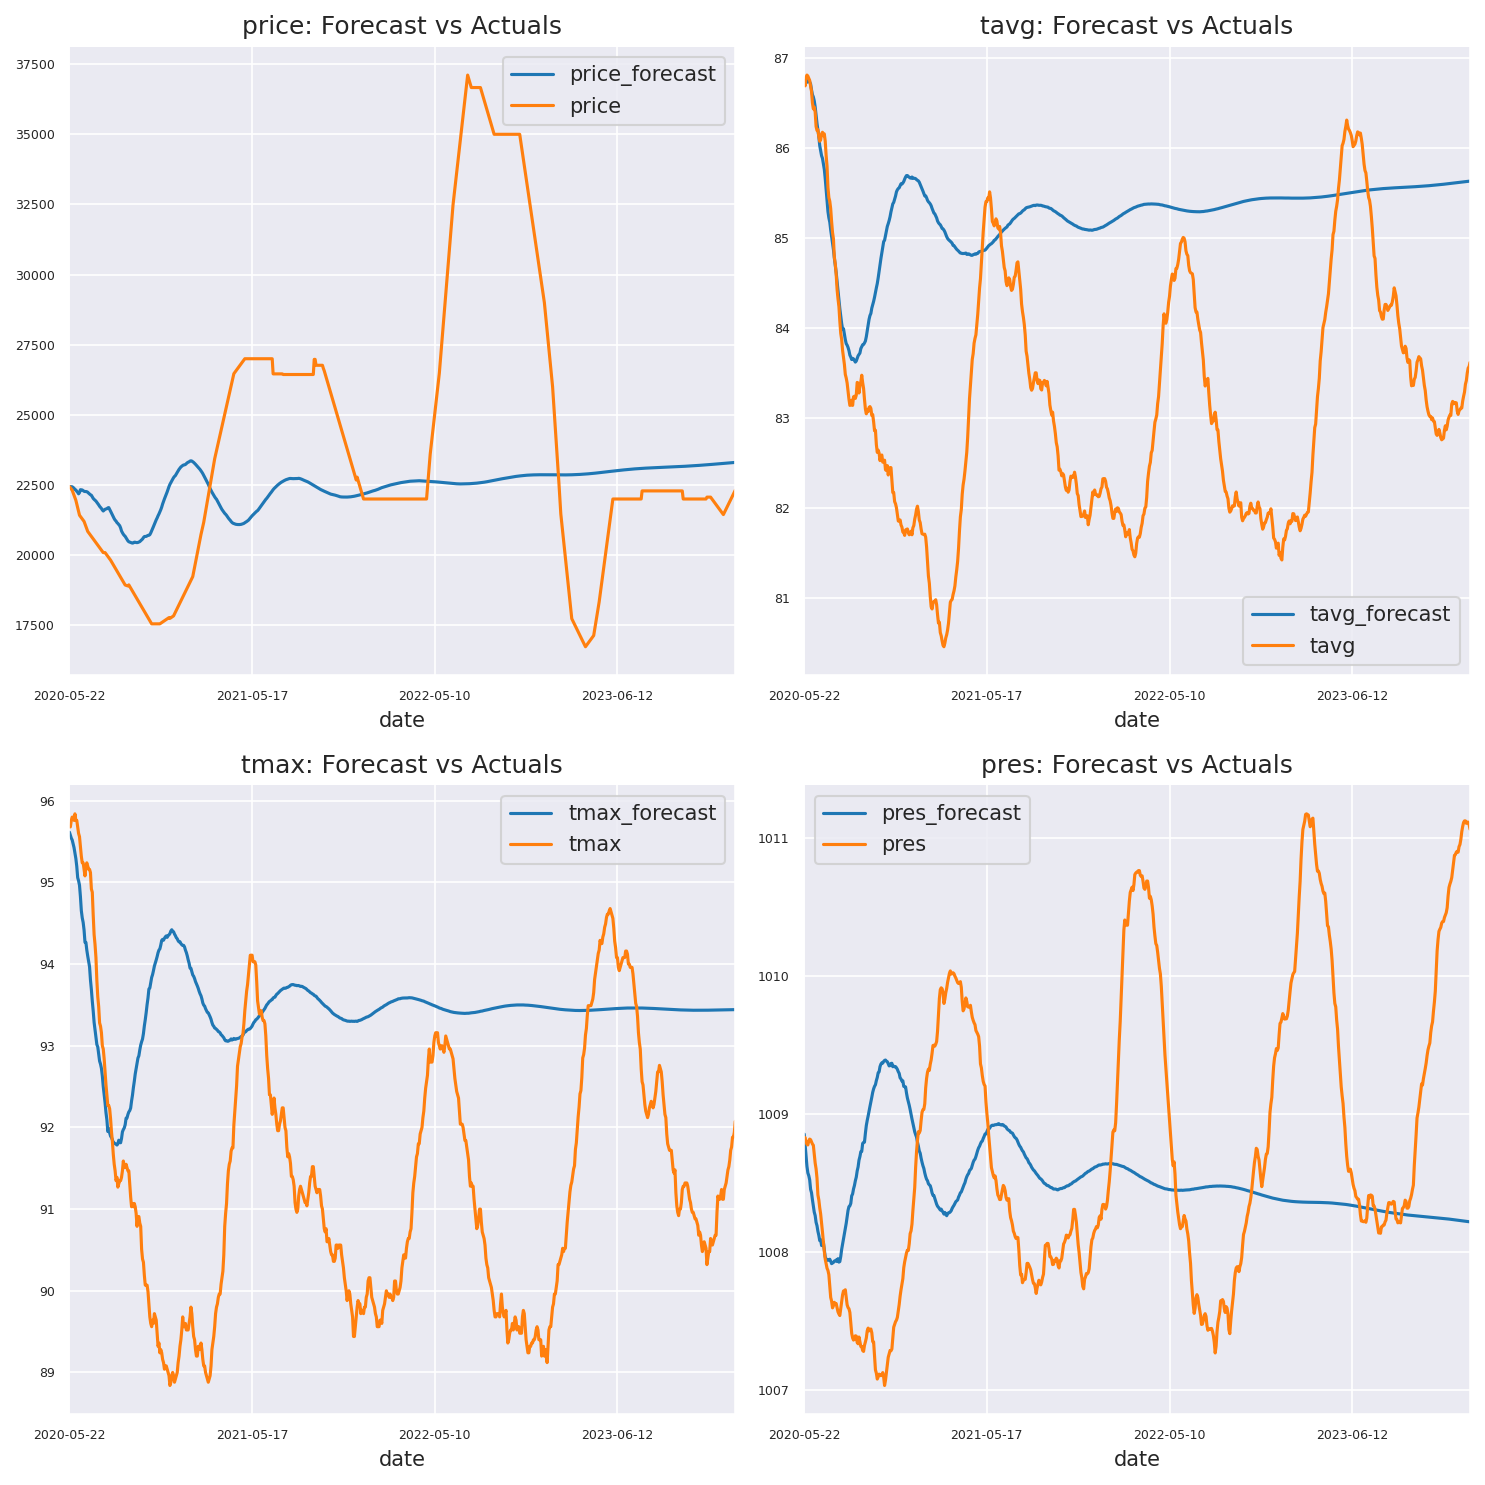

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100 # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [ ]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  14.6089
rmse   :  5338.9528


In [ ]:
import joblib
joblib.dump(model_var, var_file_name)
from google.colab import files
files.download(var_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## VARMA Model

Mô hình Vector Autoregressive Moving Average (VARMA) là sự kết hợp của mô hình VAR và mô hình VMA, giúp trong việc mô hình hóa chuỗi thời gian đa biến bằng cách xem xét cả thứ tự của lag và thứ tự của trung bình di chuyển (p và q) trong mô hình.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
columns_train = fillter_feature

Chọn tham số (p, q) cho mô hình VARMA còn là sự kết hợp với mô hình ARIMA để tìm được bộ tham số tốt nhất cho tập dữ liệu giá. Sau đó áp dụng vào mô hình với dữ liệu đa biến để tăng tốc độ và đảm bảo mô hình có độ chính xác cao.  

In [ ]:
pq = []
for name, column in df_differenced[columns_train].items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : price
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18567.499, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18596.086, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18568.411, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18566.376, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18594.086, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18567.488, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18569.482, Time=1.73 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=18564.377, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18565.500, Time=0.84 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=18565.489, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18566.412, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=18567.483, Time=1.50 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.633 seconds
optimal order for:price is: (0, 1, 1)

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model_varma = VARMAX(df_differenced[columns_train], order=(3,2),trends = 'n').fit( disp=False)


In [ ]:
result = model_varma.forecast(len(df_test))

In [ ]:
inv_res = inverse_diff(df_train[columns_train], result)

Đánh giá mô hình

In [ ]:
accuracy_prod = forecast_accuracy(inv_res['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  15.0827
rmse   :  5198.4838


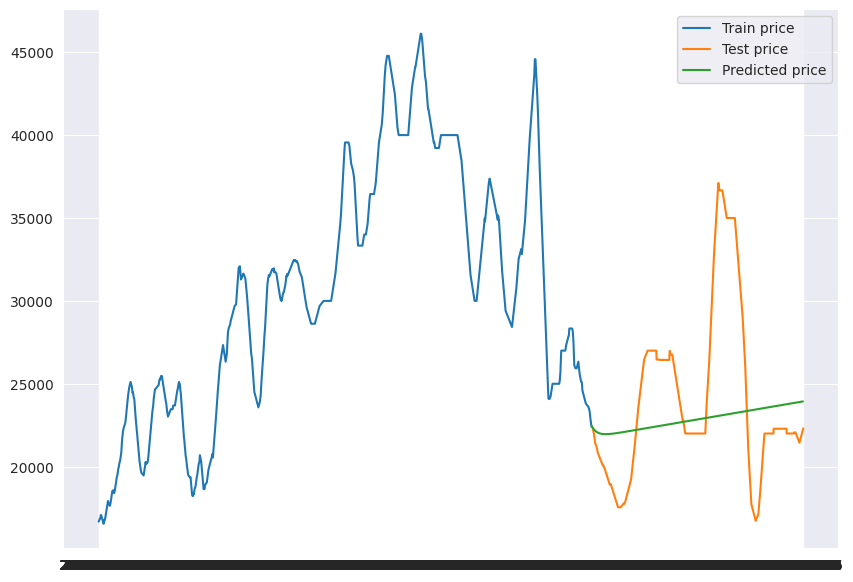

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(inv_res[str(i)+'_forecast'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

Để kiểm tra hiệu suất mô hình đã xây dựng, chúng tôi đánh giá hiệu suất trên tập huấn luyện và kiểm tra với việc tính sai số rmse và mape. 

Sau khi hoàn thành huấn luyện và đánh giá hiệu suất mô hình, chúng tôi tinh chỉnh các tham số, huấn luyện lại mô hình nhiều lần để tìm ra mô hình với bộ tham số thật tối ưu. 

In [ ]:
import joblib
from google.colab import drive

drive.mount('/content/drive')

var_file_name = 'var_gia_cam_thoi_tiet.joblib'
varma_file_name = 'varma_cam_lua_thoi_tiet.joblib'

joblib.dump(model_varma, '/content/drive/MyDrive/model/' + varma_file_name)


joblib.dump(model_var, '/content/drive/MyDrive/model/' + var_file_name)

Mounted at /content/drive


['/content/drive/MyDrive/model/var_gia_cam_thoi_tiet.joblib']